In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import quandl

In [2]:
start = pd.to_datetime('2012-01-01')
end = pd.to_datetime('2017-01-01')


In [3]:
aapl = quandl.get('WIKI/AAPL.11', start_date = start, end_date = end)
cisco = quandl.get('WIKI/CSCO.11', start_date = start, end_date = end)
ibm = quandl.get('WIKI/IBM.11', start_date = start, end_date = end)
amzn = quandl.get('WIKI/AMZN.11', start_date = start, end_date = end)


In [4]:
stocks = pd.concat([aapl,cisco,ibm,amzn], axis=1)
stocks.columns = ['aapl', 'cisco', 'ibm', 'amzn']
stocks.pct_change(1).mean()

aapl     0.000750
cisco    0.000599
ibm      0.000081
amzn     0.001328
dtype: float64

In [5]:
stocks.pct_change(1).corr()

,aapl,cisco,ibm,amzn
aapl,1.000000,0.301990,0.297498,0.235487
cisco,0.301990,1.000000,0.424672,0.284470
ibm,0.297498,0.424672,1.000000,0.258492
amzn,0.235487,0.284470,0.258492,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000239614CA908>,
      dtype=object)

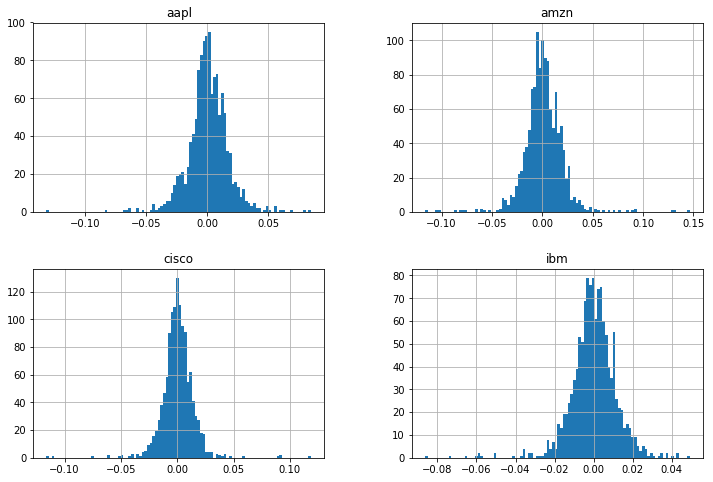

In [6]:
log_return = np.log(stocks/stocks.shift(1))
log_return.hist(bins=100, figsize=(12,8))

In [7]:
np.random.seed(101)


num_ports = 5000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    # Weights
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)
    
    # Save Weights
    all_weights[ind, :] = weights

    # Expected Return
    ret_arr[ind] = np.sum( (log_return.mean() * weights * 252))

    # Expected volatility
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]
    
    

Text(0, 0.5, 'Return')

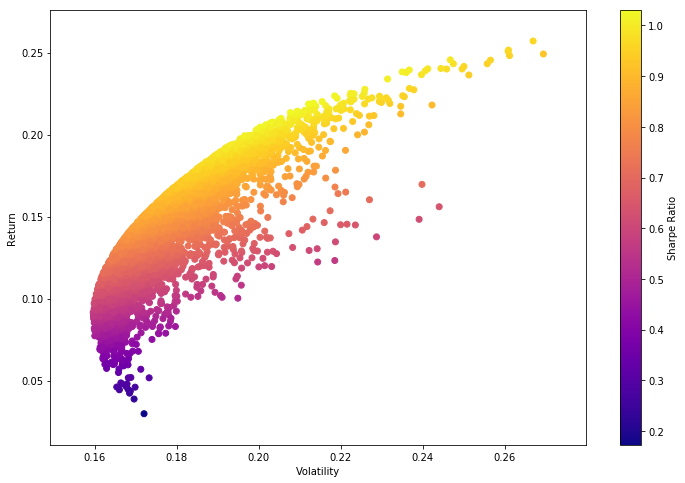

In [8]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

In [9]:
saa = sharpe_arr.argmax()
sharpe_arr.argmax()

1420

In [10]:
all_weights[1420, :]

array([0.26188068, 0.20759516, 0.00110226, 0.5294219 ])

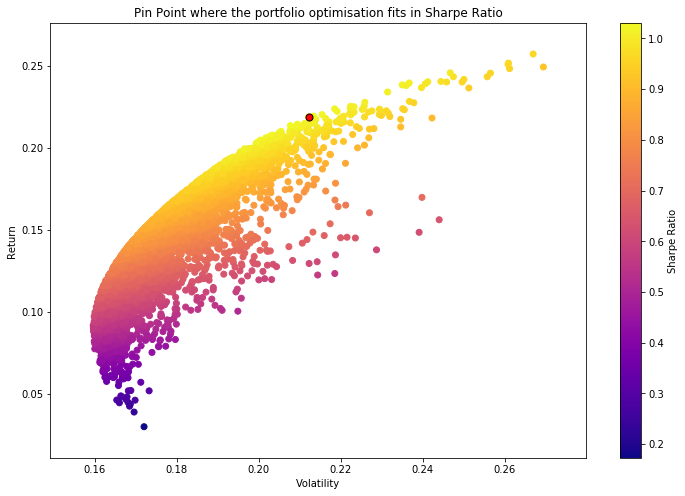

In [11]:
max_sr_ret = ret_arr[saa]
max_sr_vol = vol_arr[saa]

plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Pin Point where the portfolio optimisation fits in Sharpe Ratio')

plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50, edgecolors='black')

In [12]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

In [13]:
from scipy.optimize import minimize

def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 is the sum of the weights is 1
    return np.sum(weights) - 1

constraint = ({'type': 'eq', 'fun':check_sum})
bounds = ((0,1),(0,1),(0,1),(0,1))
init_guess = [0.25, 0.25, 0.25, 0.25]

opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=constraint)
opt_results

     fun: -1.0307168703349403
     jac: array([ 5.64306974e-05,  4.18424606e-05,  3.39921713e-01, -4.45097685e-05])
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.26628977, 0.20418982, 0.        , 0.5295204 ])

In [14]:
for stock_df in (aapl, cisco, ibm, amzn):
     stock_df['Normed Return'] = stock_df['Adj. Close'] / stock_df.iloc[0]['Adj. Close']
    

In [15]:
for stock_df, allo in zip((aapl, cisco, ibm, amzn), opt_results.x):
    stock_df['Allocation'] = stock_df['Normed Return']*allo

In [16]:
for stock_df in (aapl, cisco, ibm, amzn):
     stock_df['Position Values'] = stock_df['Allocation'] * 1000000

In [17]:
all_pos_vals = [aapl['Position Values'], cisco['Position Values'], ibm['Position Values'], amzn['Position Values']]

portfolio_val = pd.concat(all_pos_vals, axis=1)

In [18]:
portfolio_val.columns = ['AAPL Pos', 'CISCO Pos', 'IBM Pos', 'AMZN Pos']

In [19]:
portfolio_val['Total Pos'] = portfolio_val.sum(axis=1)

Text(0.5, 1.0, 'Total Portfolio Value')

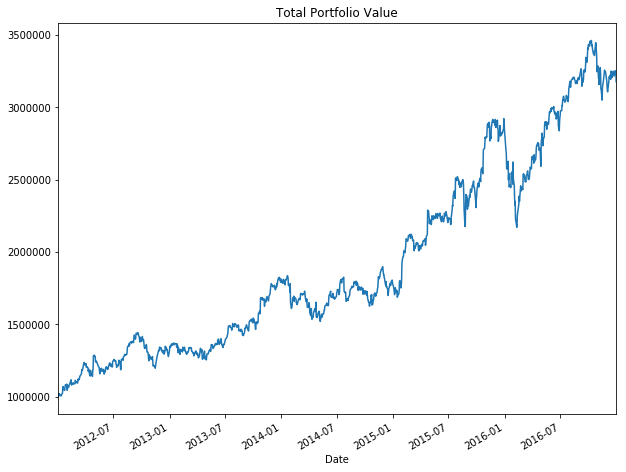

In [20]:
portfolio_val['Total Pos'].plot(figsize=(10,8))
plt.title('Total Portfolio Value')

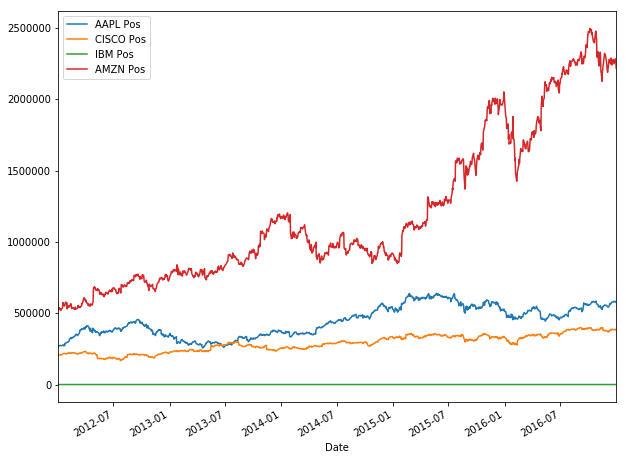

In [21]:
portfolio_val.drop('Total Pos', axis=1).plot(figsize=(10,8))

In [22]:
#Portfolio Stats

portfolio_val['Daily Return'] = portfolio_val['Total Pos'].pct_change(1)

In [23]:
portfolio_val['Daily Return'].mean()

0.0010193630373592879

In [24]:
portfolio_val['Daily Return'].std()

0.014140484585124423

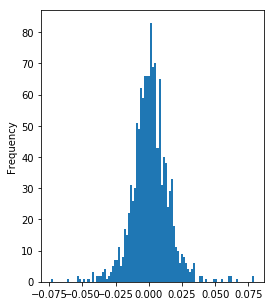

In [25]:
portfolio_val['Daily Return'].plot(kind = 'hist', bins=100, figsize=(4,5))

In [26]:
cumulative_return = 100 * (portfolio_val['Total Pos'][-1]/portfolio_val['Total Pos'][0] -1)

In [27]:
#Total overall return
cumulative_return

217.5743609396548

In [28]:
#Current Portfolio Value
portfolio_val['Total Pos'][-1]

3175743.6093965485

In [29]:
#Sharpe Ratio

SR = portfolio_val['Daily Return'].mean() / portfolio_val['Daily Return'].std()
SR

0.0720882676419479

In [30]:
# Annualised Sharpe Ratio (greater than 1=good 2=great 3=excellent)

ASR = (252**0.5) * SR
ASR

1.1443657717563525